# Analysis of SL Cricket Players Performance in ODI format

**Introduction**
* This notebook aims to provide a comprehensive analysis of the performance of Sri Lankan cricket players in the ODI format. We will explore various metrics such as capturing every ball bowled, the runs scored, the type of dismissal, and more. This analysis will help us identify key players and their contributions to the team, as well as trends and patterns in player performances.

**Objectives**
* We aim to analyze the all-time performance of Sri Lanka batters and bowlers, including performance by batting position, partnerships, boundary statistics, wicket-taking ability, and dismissal patterns, using comprehensive ball-by-ball and match information data (2002-2023).

**Dataset**
* This dataset encompasses detailed *ball-by-ball* data and *match information* for various cricket matches available on the [Cricsheet](https://cricsheet.org) website.

**Data Details** *italicised text*
* Ball-by-Ball Data: Includes details such as the batting team, over, batter, bowler, runs scored, extras, dismissal information, etc.
* Match Info: Contains metadata about the match, such as the venue, teams playing, toss decision, match outcome, and other relevant details.

**Methodology**
* Data Extraction: Querying the dataset to extract relevant performance metrics for each player.

**Tools and Libraries**

*   Apache Spark: For efficient data querying and processing.
*   Pandas: For data manipulation and analysis.
*   Matplotlib: For creating visualizations.
*   Colab: Hosted Jupyter Notebook service.

## Import Libraries

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless &> /dev/null

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull, count, min, max
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Load dataset

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
spark = SparkSession.builder \
    .appName("Sri Lanka Cricket Performance Analysis") \
    .getOrCreate()

In [5]:
ball_by_ball_df = spark.read.csv("/content/gdrive/My Drive/AI/Colab Notebooks/DC/Assignment/ball_by_ball_data.csv", header=True, inferSchema=True)
match_info_df = spark.read.csv("/content/gdrive/My Drive/AI/Colab Notebooks/DC/Assignment/match_info.csv", header=True, inferSchema=True)

In [6]:
ball_by_ball_df.show()

+--------+-----------+----+--------+---------+-----------+--------------+------+----------+-----------+----------+-------+---------+---------+---------------+-----------+--------------+---------------+----------------+------------------+----------------+---------------+
|Match ID|Inning Team|Over|  Batter|   Bowler|Non-striker|Runs by Batter|Extras|Total Runs|Wicket Kind|Player Out|Fielder|Review By|   Umpire|Review Decision|Review Type|Replacement In|Replacement Out|Replacement Team|Replacement Reason|Replacement Role|Current Wickets|
+--------+-----------+----+--------+---------+-----------+--------------+------+----------+-----------+----------+-------+---------+---------+---------------+-----------+--------------+---------------+----------------+------------------+----------------+---------------+
| 1034819|    England|   0|  JJ Roy| UT Yadav|   AD Hales|             0|     0|         0|       NULL|      NULL|   NULL|     NULL|     NULL|           NULL|       NULL|          NULL|  

In [7]:
match_info_df.show()

+--------+------------+----------+----------+-----------------+-------+-------------+-----------+-----------+-----------+-------------+--------------------+-----------+---------------+----------+-------------------+--------------------+------------------+-----------+------+---------------+-----------------+---------------+-------------+
|Match ID|        City|      Date|Match Type|Match Type Number| Season|    Team Type|     Team 1|     Team 2|Toss Winner|Toss Decision|               Venue|     Winner|win_margin_type|Win Margin|Player of the Match|          Event Name|Event Match Number|Event Stage|Gender|       Umpire 1|         Umpire 2|      TV Umpire|Match Referee|
+--------+------------+----------+----------+-----------------+-------+-------------+-----------+-----------+-----------+-------------+--------------------+-----------+---------------+----------+-------------------+--------------------+------------------+-----------+------+---------------+-----------------+--------------

# Data Cleansing

In [8]:
# Date Range
first_date = match_info_df.select(min("Date")).collect()[0][0]
last_date = match_info_df.select(max("Date")).collect()[0][0]
print("First Date:", first_date)
print("Last Date:", last_date)

# Unique values for Match Type, Team Type, Team 1, Team 2, Toss Winner, Toss Decision, win_margin_type, Gender.
print("Unique values for Match Type:", match_info_df.select("Match Type").distinct().collect())
print("Unique values for Team Type:", match_info_df.select("Team Type").distinct().collect())
print("Unique values for Team 1:", match_info_df.select("Team 1").distinct().collect())
print("Unique values for Team 2:", match_info_df.select("Team 2").distinct().collect())
print("Unique values for Toss Winner:", match_info_df.select("Toss Winner").distinct().collect())
print("Unique values for Toss Decision:", match_info_df.select("Toss Decision").distinct().collect())
print("Unique values for win_margin_type:", match_info_df.select("win_margin_type").distinct().collect())
print("Unique values for Gender:", match_info_df.select("Gender").distinct().collect())

# Drop unwanted columns in ball_by_ball_df and match_info_df
ball_by_ball_df = ball_by_ball_df.drop("Match Type", "Team Type", "Team 2", "Umpire 1", "Umpire 2", "Review By", "Umpire", "Review Decision", "Review Type", "Replacement In", "Replacement Out", "Replacement Team", "Replacement Reason", "Replacement Role", "Player Out")
match_info_df = match_info_df.drop("City", "Umpire 1", "Season", "Venue", "Umpire 2", "Event Name", "TV Umpire", "Match Referee")

# Show the ball_by_ball_df and match_info_df

print(match_info_df.count())
print(ball_by_ball_df.count())

First Date: 2002-12-29
Last Date: 2023-09-27
Unique values for Match Type: [Row(Match Type='ODI')]
Unique values for Team Type: [Row(Team Type='international')]
Unique values for Team 1: [Row(Team 1='Jersey'), Row(Team 1='Afghanistan'), Row(Team 1='Sri Lanka'), Row(Team 1='India'), Row(Team 1='Bangladesh'), Row(Team 1='West Indies'), Row(Team 1='Ireland'), Row(Team 1='Hong Kong'), Row(Team 1='Oman'), Row(Team 1='United States of America'), Row(Team 1='Zimbabwe'), Row(Team 1='Namibia'), Row(Team 1='Africa XI'), Row(Team 1='United Arab Emirates'), Row(Team 1='Canada'), Row(Team 1='Kenya'), Row(Team 1='New Zealand'), Row(Team 1='England'), Row(Team 1='Australia'), Row(Team 1='Papua New Guinea'), Row(Team 1='Nepal'), Row(Team 1='South Africa'), Row(Team 1='Bermuda'), Row(Team 1='Scotland'), Row(Team 1='Pakistan'), Row(Team 1='Netherlands')]
Unique values for Team 2: [Row(Team 2='Jersey'), Row(Team 2='Afghanistan'), Row(Team 2='Sri Lanka'), Row(Team 2='India'), Row(Team 2='Asia XI'), Row(Te

In [9]:
# check missing values available col
match_info_df.select([count(when(isnull(c), c)).alias(c) for c in match_info_df.columns]).show()


+--------+----+----------+-----------------+---------+------+------+-----------+-------------+------+---------------+----------+-------------------+------------------+-----------+------+
|Match ID|Date|Match Type|Match Type Number|Team Type|Team 1|Team 2|Toss Winner|Toss Decision|Winner|win_margin_type|Win Margin|Player of the Match|Event Match Number|Event Stage|Gender|
+--------+----+----------+-----------------+---------+------+------+-----------+-------------+------+---------------+----------+-------------------+------------------+-----------+------+
|       0|   0|         0|                0|        0|     0|     0|          0|            0|     0|            121|       121|                152|               111|       2275|     0|
+--------+----+----------+-----------------+---------+------+------+-----------+-------------+------+---------------+----------+-------------------+------------------+-----------+------+



In [10]:
# check missing values available col
ball_by_ball_df.select([count(when(isnull(c), c)).alias(c) for c in ball_by_ball_df.columns]).show()


+--------+-----------+----+------+------+-----------+--------------+------+----------+-----------+-------+---------------+
|Match ID|Inning Team|Over|Batter|Bowler|Non-striker|Runs by Batter|Extras|Total Runs|Wicket Kind|Fielder|Current Wickets|
+--------+-----------+----+------+------+-----------+--------------+------+----------+-----------+-------+---------------+
|       0|          0|   0|     0|     0|          0|             0|     0|         0|    1231818|1243825|              0|
+--------+-----------+----+------+------+-----------+--------------+------+----------+-----------+-------+---------------+



# Filter Sri Lanka Cricket match info

In [11]:
match_info_df.createOrReplaceTempView("match_info")
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")

In [12]:
sri_lanka_matches = match_info_df.filter((match_info_df['Team 1'] == 'Sri Lanka') | (match_info_df['Team 2'] == 'Sri Lanka'))
sri_lanka_innings = ball_by_ball_df.join(sri_lanka_matches, 'Match ID', 'inner').filter(col('Inning Team') == 'Sri Lanka')
sri_lanka_balling = ball_by_ball_df.join(sri_lanka_matches, 'Match ID', 'inner').filter(col('Inning Team') != 'Sri Lanka')

In [13]:
sri_lanka_matches.createOrReplaceTempView("sri_lanka_matches")
sri_lanka_innings.createOrReplaceTempView("sri_lanka_innings")
sri_lanka_balling.createOrReplaceTempView("sri_lanka_balling")

In [14]:
print(sri_lanka_matches.count())
sri_lanka_matches.show(10)

458
+--------+----------+----------+-----------------+-------------+------------+-----------+-----------+-------------+------------+---------------+----------+-------------------+------------------+-----------+------+
|Match ID|      Date|Match Type|Match Type Number|    Team Type|      Team 1|     Team 2|Toss Winner|Toss Decision|      Winner|win_margin_type|Win Margin|Player of the Match|Event Match Number|Event Stage|Gender|
+--------+----------+----------+-----------------+-------------+------------+-----------+-----------+-------------+------------+---------------+----------+-------------------+------------------+-----------+------+
| 1022351|2017-06-03|       ODI|             3877|international|South Africa|  Sri Lanka|  Sri Lanka|        field|South Africa|           runs|      96.0|        Imran Tahir|               3.0|       NULL|  male|
| 1022361|2017-06-08|       ODI|             3882|international|       India|  Sri Lanka|  Sri Lanka|        field|   Sri Lanka|        wick

In [15]:
print(sri_lanka_innings.count())
sri_lanka_innings.show(10)

120983
+--------+-----------+----+--------------+-------------+--------------+--------------+------+----------+-----------+-------+---------------+----------+----------+-----------------+-------------+-----------+---------+-----------+-------------+-----------+---------------+----------+-------------------+------------------+-----------+------+
|Match ID|Inning Team|Over|        Batter|       Bowler|   Non-striker|Runs by Batter|Extras|Total Runs|Wicket Kind|Fielder|Current Wickets|      Date|Match Type|Match Type Number|    Team Type|     Team 1|   Team 2|Toss Winner|Toss Decision|     Winner|win_margin_type|Win Margin|Player of the Match|Event Match Number|Event Stage|Gender|
+--------+-----------+----+--------------+-------------+--------------+--------------+------+----------+-----------+-------+---------------+----------+----------+-----------------+-------------+-----------+---------+-----------+-------------+-----------+---------------+----------+-------------------+------------

In [16]:
print(sri_lanka_balling.count())
sri_lanka_balling.show(10)

117059
+--------+-----------+----+----------+---------------+-----------+--------------+------+----------+-----------+-------+---------------+----------+----------+-----------------+-------------+-----------+---------+-----------+-------------+-----------+---------------+----------+-------------------+------------------+-----------+------+
|Match ID|Inning Team|Over|    Batter|         Bowler|Non-striker|Runs by Batter|Extras|Total Runs|Wicket Kind|Fielder|Current Wickets|      Date|Match Type|Match Type Number|    Team Type|     Team 1|   Team 2|Toss Winner|Toss Decision|     Winner|win_margin_type|Win Margin|Player of the Match|Event Match Number|Event Stage|Gender|
+--------+-----------+----+----------+---------------+-----------+--------------+------+----------+-----------+-------+---------------+----------+----------+-----------------+-------------+-----------+---------+-----------+-------------+-----------+---------------+----------+-------------------+------------------+--------

# 1. Most runs for Sri Lanka in ODIs

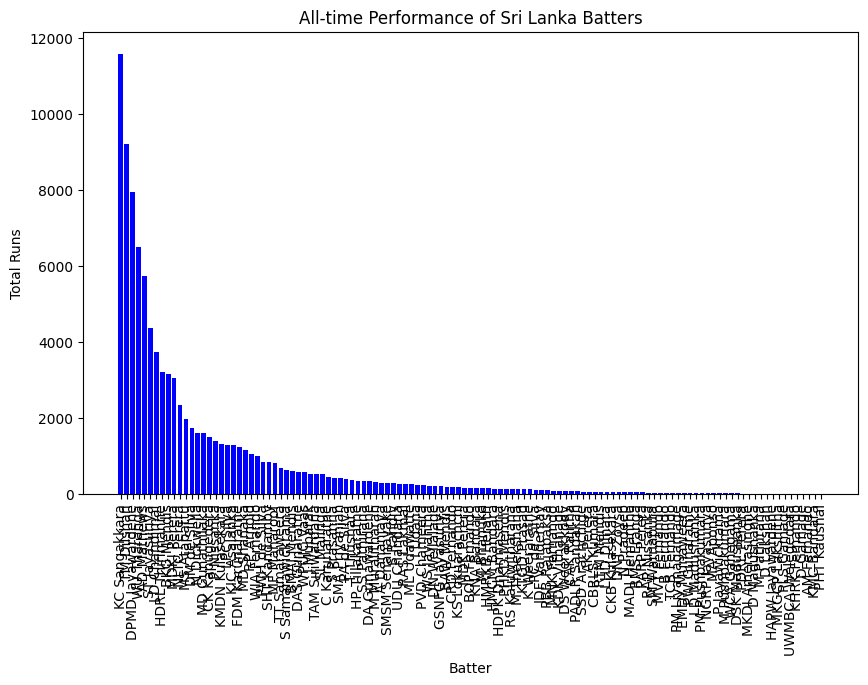

In [17]:
batters_performance_query = """
SELECT
    Batter,
    SUM(CAST(`Runs by Batter` AS INT)) AS Total_Runs,
    COUNT(*) AS Balls_Faced,
    SUM(CASE WHEN `Wicket Kind` IS NOT NULL THEN 1 ELSE 0 END) AS Outs,
    SUM(CASE WHEN `Wicket Kind` IS NULL THEN 1 ELSE 0 END) AS Not_Outs
FROM sri_lanka_innings
GROUP BY Batter
ORDER BY Total_Runs DESC
"""
batters_performance = spark.sql(batters_performance_query)
batters_performance_df = batters_performance.toPandas()

# Function to create bar plots
def create_bar_plot(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    df = df.sort_values(by=y_col, ascending=False)
    plt.bar(df[x_col], df[y_col], color='blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Plotting all-time performance of Sri Lanka batters
create_bar_plot(batters_performance_df, 'Batter', 'Total_Runs', 'All-time Performance of Sri Lanka Batters', 'Batter', 'Total Runs')


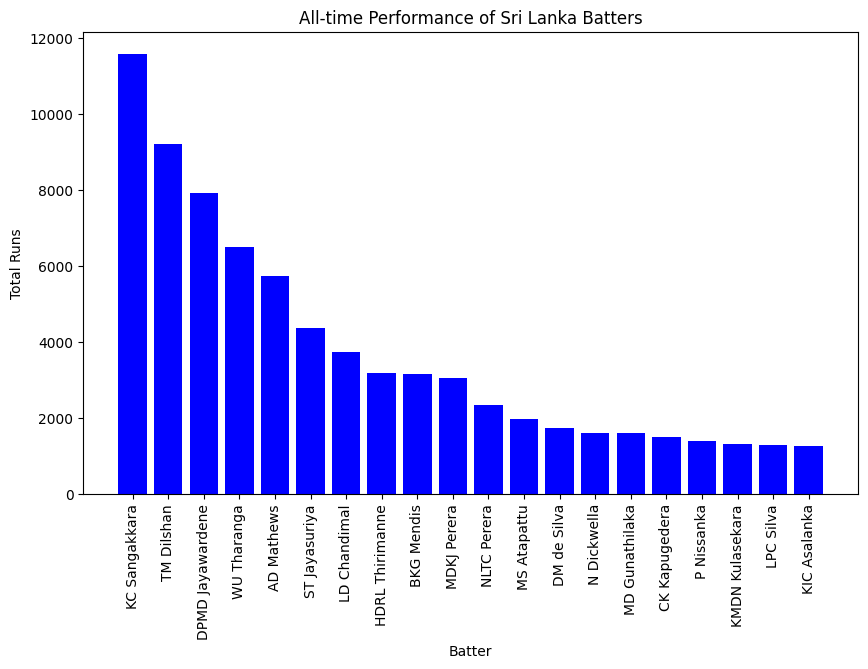

In [18]:
# Plotting all-time performance of Sri Lanka batters
create_bar_plot(batters_performance_df.head(20), 'Batter', 'Total_Runs', 'All-time Performance of Sri Lanka Batters', 'Batter', 'Total Runs')


# 2. Best scorer each year

In [19]:
# Best scorer each year
best_scorer_by_year_query = """
SELECT
    YEAR(Date) AS Year,
    Batter,
    SUM(CAST(`Runs by Batter` AS INT)) AS Total_Runs
FROM sri_lanka_innings
GROUP BY Year, Batter
ORDER BY Year, Total_Runs DESC
"""
best_scorer_by_year = spark.sql(best_scorer_by_year_query)
best_scorer_by_year_df = best_scorer_by_year.toPandas()

# Displaying the best scorer for each year
best_scorer_by_year_df = best_scorer_by_year_df.sort_values(by=['Year', 'Total_Runs'], ascending=[True, False])
best_scorer_by_year_df = best_scorer_by_year_df.loc[best_scorer_by_year_df.groupby('Year')['Total_Runs'].idxmax()]

# Display the best scorer for each year
print(best_scorer_by_year_df[['Year', 'Batter', 'Total_Runs']])

     Year         Batter  Total_Runs
0    2003  ST Jayasuriya         725
24   2004  KC Sangakkara         713
45   2005    MS Atapattu         359
61   2006  KC Sangakkara        1096
83   2007  ST Jayasuriya         766
104  2008  KC Sangakkara         909
127  2009     TM Dilshan        1000
150  2010     TM Dilshan         921
174  2011  KC Sangakkara        1127
199  2012  KC Sangakkara        1184
221  2013  KC Sangakkara        1201
245  2014  KC Sangakkara        1256
271  2015     TM Dilshan        1207
301  2016   LD Chandimal         556
331  2017    WU Tharanga        1011
365  2018    NLTC Perera         415
390  2019    MDKJ Perera         646
425  2020   WIA Fernando         206
435  2021   PWH de Silva         356
467  2022     P Nissanka         491
488  2023     P Nissanka         819


# 3. Most runs for Sri Lanka in ODIs by position

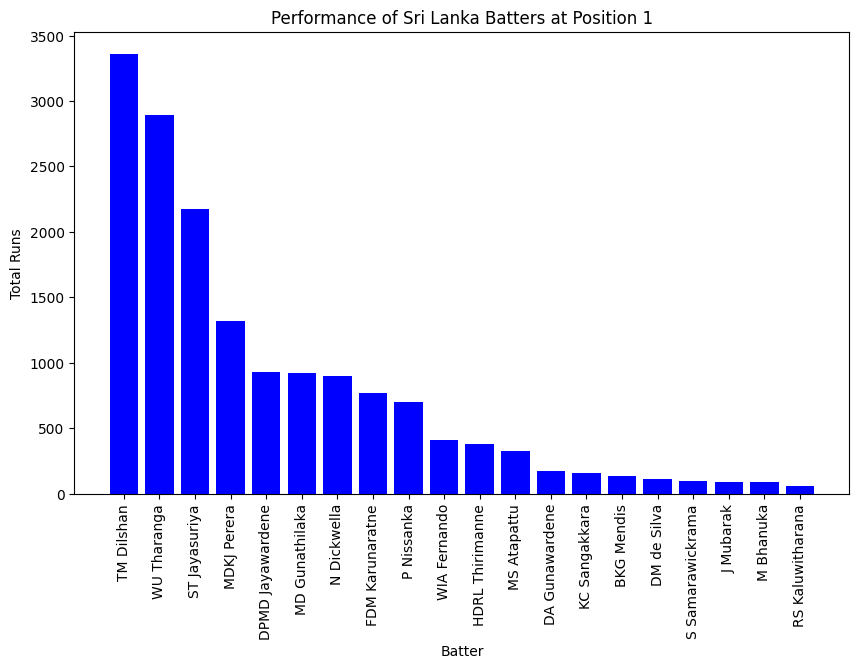

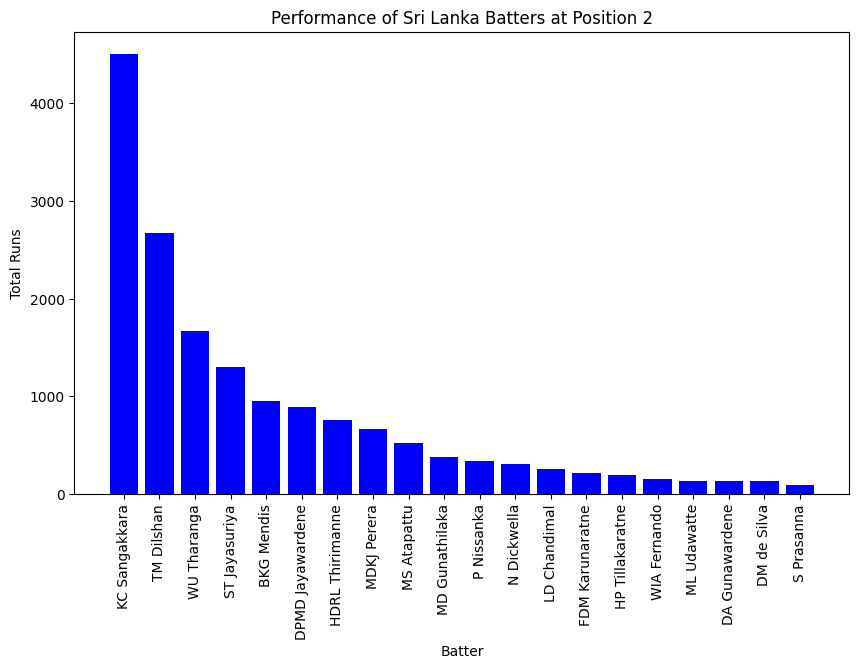

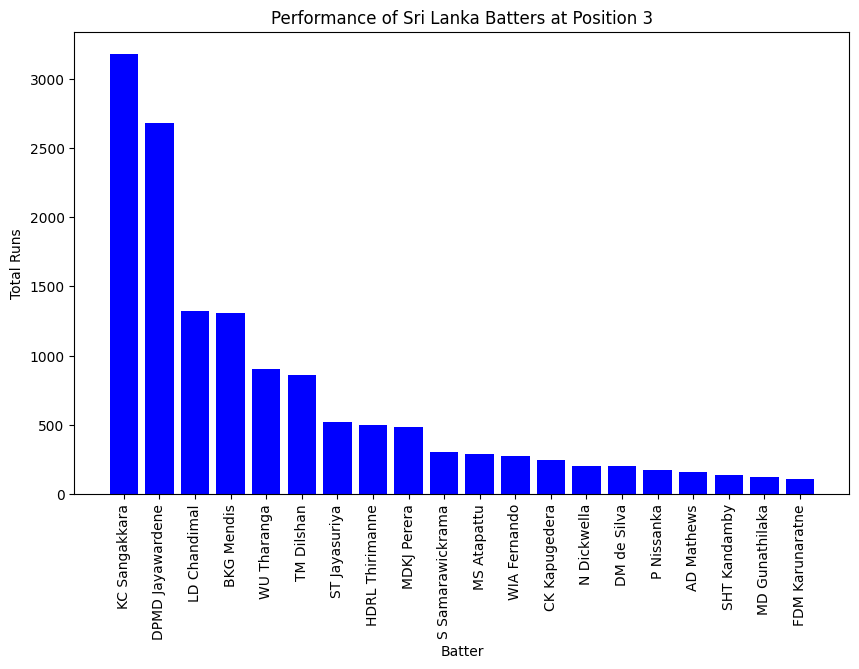

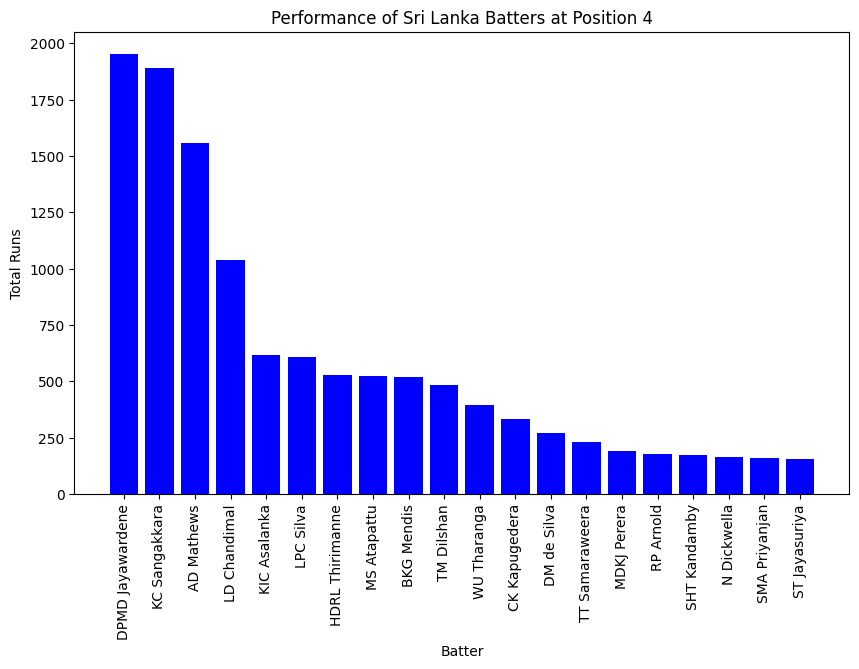

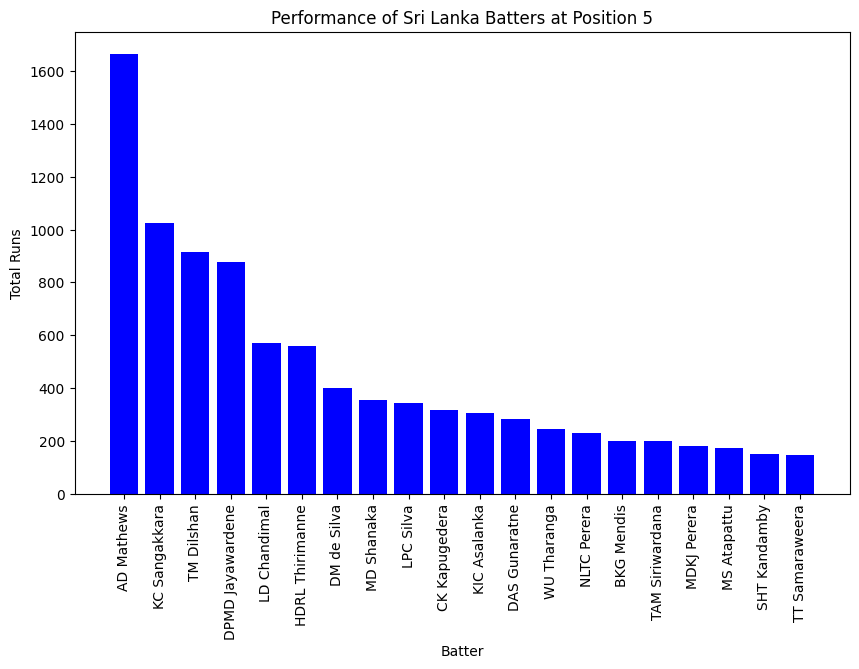

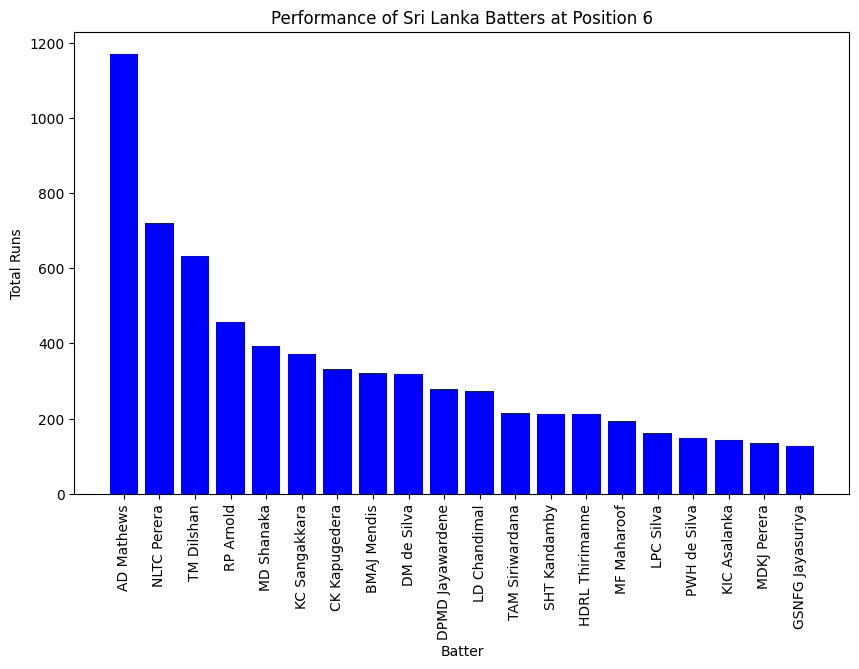

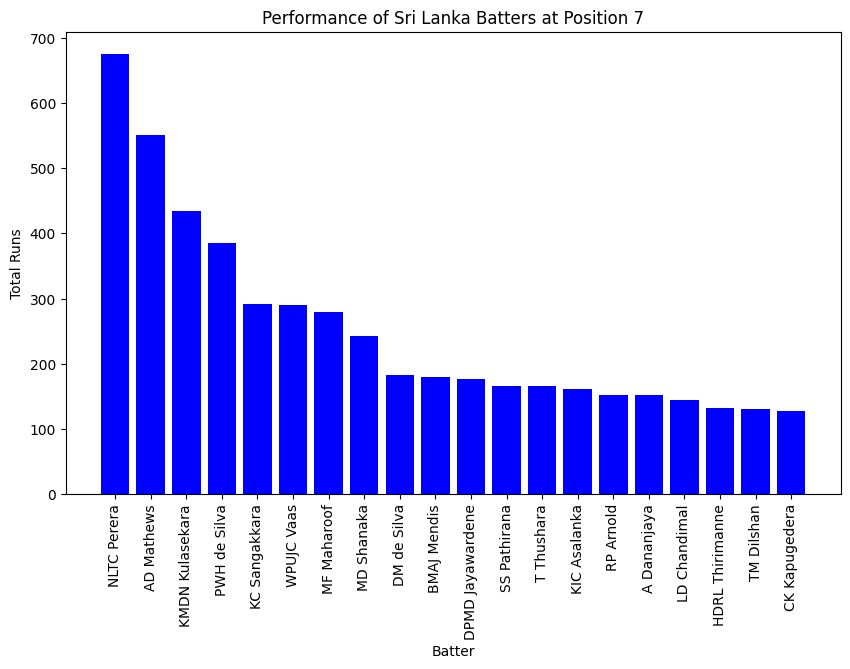

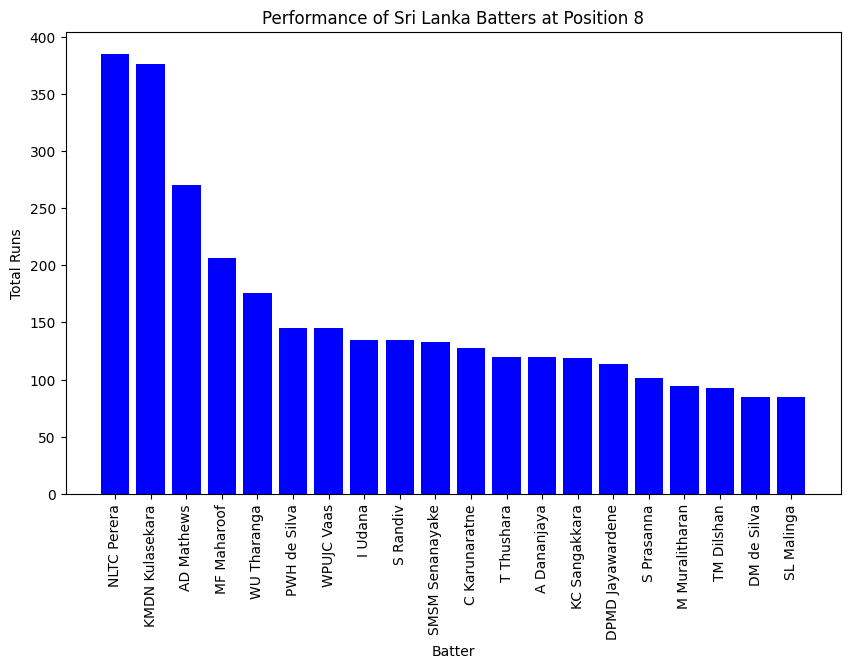

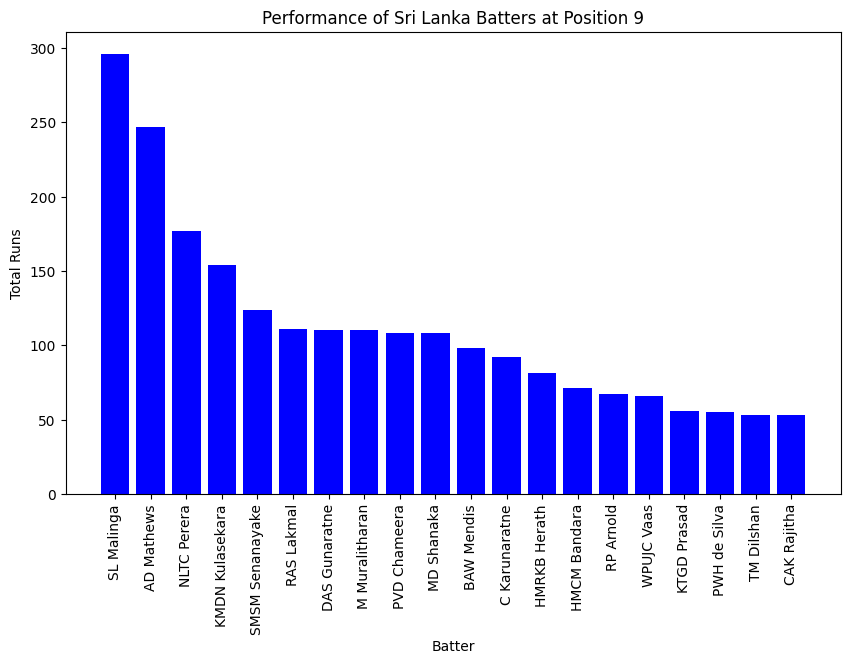

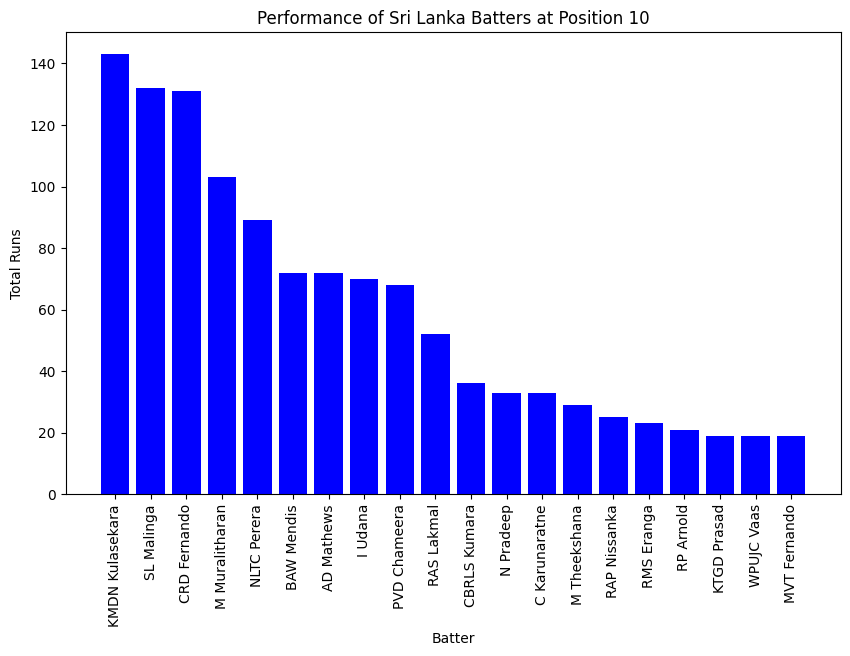

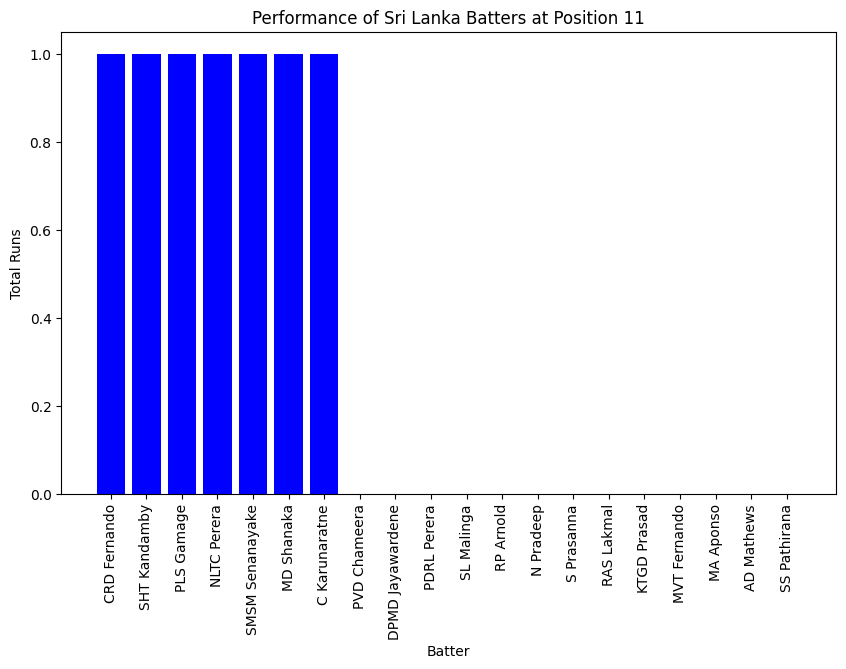

In [20]:
batters_by_position_query = """
SELECT
    Batter,
    `Current Wickets`,
    SUM(CAST(`Runs by Batter` AS INT)) AS Total_Runs  -- Aggregate runs scored by each batter at each position
FROM sri_lanka_innings
GROUP BY Batter, `Current Wickets`
ORDER by Total_Runs DESC
"""
batters_by_position = spark.sql(batters_by_position_query)
batters_by_position_df = batters_by_position.toPandas()


# Plotting all-time performance of Sri Lanka batters by position
for position in sorted(batters_by_position_df['Current Wickets'].unique()):
      position_df = batters_by_position_df[batters_by_position_df['Current Wickets'] == position]
      create_bar_plot(position_df.head(20), 'Batter', 'Total_Runs', f'Performance of Sri Lanka Batters at Position {position + 1}', 'Batter', 'Total Runs')

In [21]:
best_scorer_per_position = batters_by_position_df.loc[
    batters_by_position_df.groupby('Current Wickets')['Total_Runs'].idxmax()
]
print(best_scorer_per_position)

               Batter  Current Wickets  Total_Runs
1          TM Dilshan                0        3360
0       KC Sangakkara                1        4508
2       KC Sangakkara                2        3181
7    DPMD Jayawardene                3        1953
10         AD Mathews                4        1665
16         AD Mathews                5        1170
32        NLTC Perera                6         676
55        NLTC Perera                7         385
72         SL Malinga                8         296
132   KMDN Kulasekara                9         143
542      CRD Fernando               10           1


# 4. Highest partnerships for Sri Lanka in ODIs

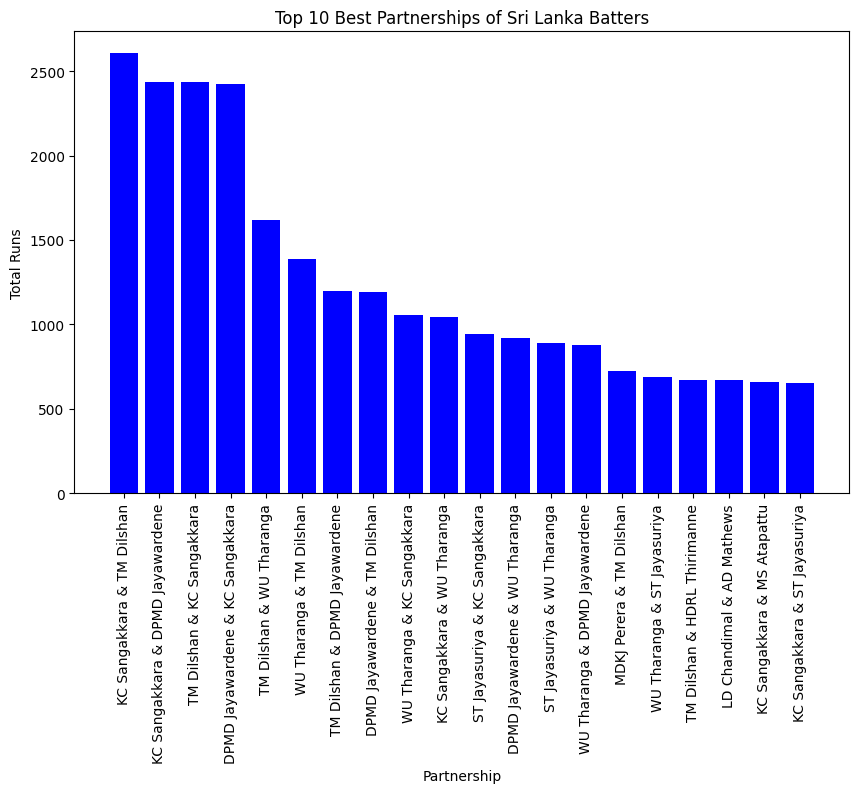

In [22]:
# Best partnerships of Sri Lanka batters
best_partnerships_query = """
SELECT
    Batter,
    `Non-striker`,
    SUM(CAST(`Runs by Batter` AS INT)) AS Total_Runs
FROM sri_lanka_innings
GROUP BY Batter, `Non-striker`
ORDER BY Total_Runs DESC
"""
best_partnerships = spark.sql(best_partnerships_query)
best_partnerships_df = best_partnerships.toPandas()
len(best_partnerships_df)

# Combine Batter and Non-striker into a single label for better readability
best_partnerships_df['Partnership'] = best_partnerships_df['Batter'] + " & " + best_partnerships_df['Non-striker']

# Plot the best partnerships
create_bar_plot(best_partnerships_df.head(20), 'Partnership', 'Total_Runs', 'Top 10 Best Partnerships of Sri Lanka Batters', 'Partnership', 'Total Runs')


# 5. Sri Lanka ODI matches batting most sixes career

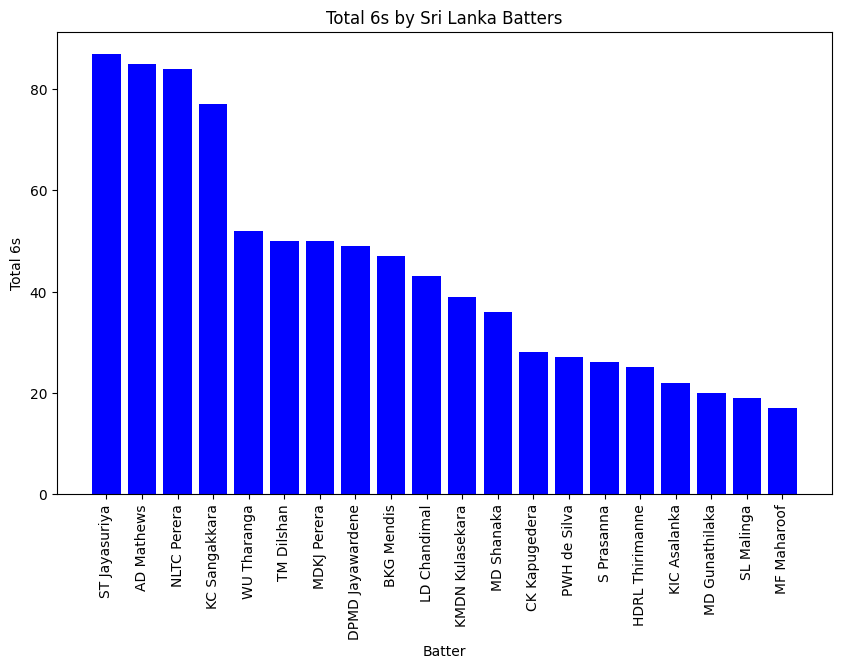

In [23]:
sixers_performance_query = """
SELECT
    Batter,
    COUNT(*) AS Total_6s
FROM sri_lanka_innings
WHERE CAST(`Runs by Batter` AS INT) = 6
GROUP BY Batter
ORDER by Total_6s DESC
"""
sixers_performance = spark.sql(sixers_performance_query)
sixers_performance_df = sixers_performance.toPandas()

# Plotting total 6s by batters
create_bar_plot(sixers_performance_df.head(20), 'Batter', 'Total_6s', 'Total 6s by Sri Lanka Batters', 'Batter', 'Total 6s')


# 5. Sri Lanka ODI matches batting most fours career

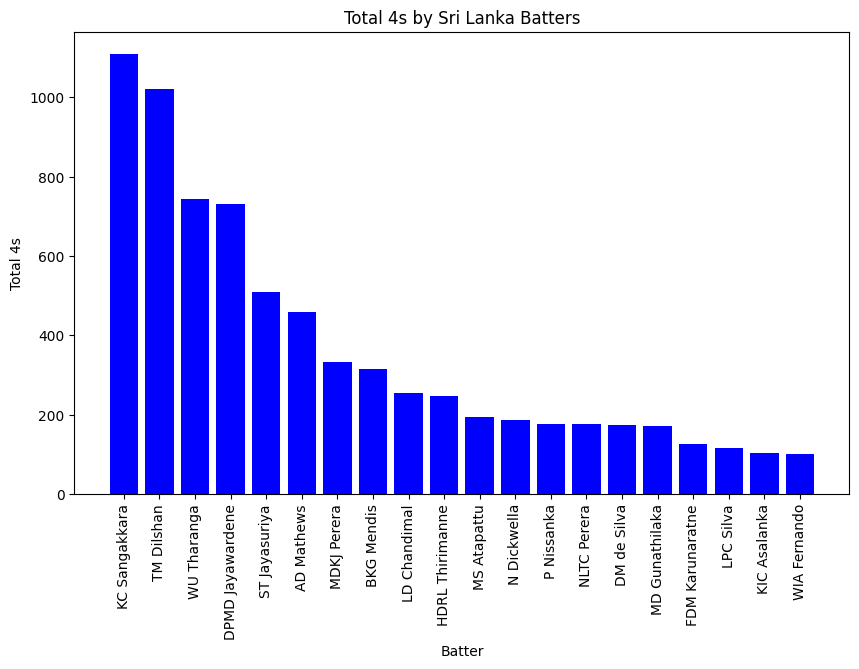

In [24]:
fours_performance_query = """
SELECT
    Batter,
    COUNT(*) AS Total_4s
FROM sri_lanka_innings
WHERE CAST(`Runs by Batter` AS INT) = 4
GROUP BY Batter
ORDER by Total_4s DESC
"""
fours_performance = spark.sql(fours_performance_query)
fours_performance_df = fours_performance.toPandas()

# Plotting total 4s by batters
create_bar_plot(fours_performance_df.head(20), 'Batter', 'Total_4s', 'Total 4s by Sri Lanka Batters', 'Batter', 'Total 4s')


# 6. Sri Lanka ODI matches batting most wicket taker

             Bowler  Total_Wickets
0        SL Malinga            329
1   KMDN Kulasekara            192
2    M Muralitharan            185
3       NLTC Perera            174
4        BAW Mendis            139
5        AD Mathews            117
6       MF Maharoof            110
7        WPUJC Vaas            110
8        RAS Lakmal            109
9      CRD Fernando            102
10       TM Dilshan             87
11    ST Jayasuriya             86
12     HMRKB Herath             69
13     PWH de Silva             67
14        N Pradeep             62
15      A Dananjaya             56
16  SMSM Senanayake             53
17     PVD Chameera             50
18       T Thushara             46
19      DM de Silva             45


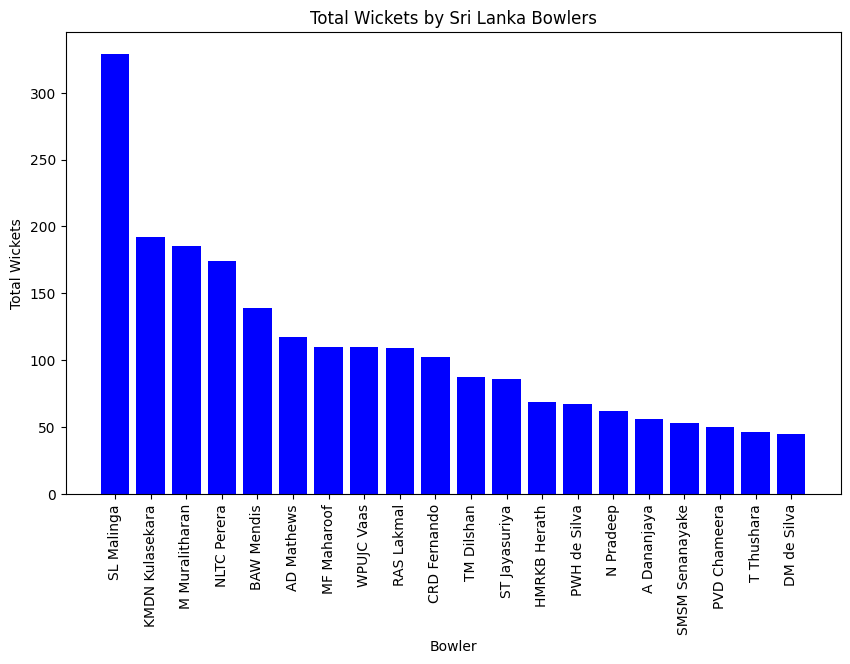

In [25]:
wickets_performance_query = """
SELECT
    Bowler,
    SUM(CASE WHEN `Wicket Kind` IS NOT NULL THEN 1 ELSE 0 END) AS Total_Wickets
FROM sri_lanka_balling
WHERE `Wicket Kind` IS NOT NULL AND `Wicket Kind` != 'run out'
GROUP BY Bowler
ORDER BY Total_Wickets DESC
"""
wickets_performance = spark.sql(wickets_performance_query)
wickets_performance_df = wickets_performance.toPandas()
print(wickets_performance_df.head(20))

# Plotting total wickets by bowlers
create_bar_plot(wickets_performance_df.head(20), 'Bowler', 'Total_Wickets', 'Total Wickets by Sri Lanka Bowlers', 'Bowler', 'Total Wickets')


# 7. Best Wicket taking SL bowler for against each country

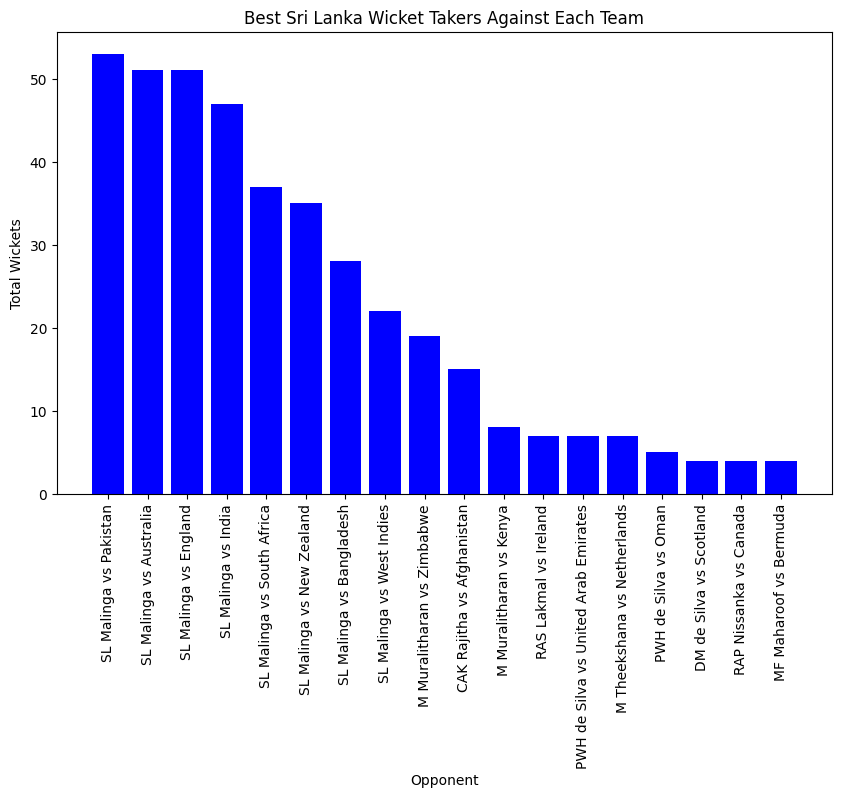

In [26]:
best_wicket_takers_query = """
SELECT
    Bowler,
    `Inning Team` AS Opponent,
    COUNT(*) AS Total_Wickets
FROM sri_lanka_balling
WHERE `Wicket Kind` IS NOT NULL
GROUP BY Bowler, `Inning Team`
ORDER BY Total_Wickets DESC
"""
best_wicket_takers = spark.sql(best_wicket_takers_query)
best_wicket_takers_df = best_wicket_takers.toPandas()

# the best wicket-taker for each opponent
best_wicket_taker_each_opponent = best_wicket_takers_df.loc[
    best_wicket_takers_df.groupby('Opponent')['Total_Wickets'].idxmax()
].reset_index(drop=True)
best_wicket_taker_each_opponent['Bowler_Opponent'] = best_wicket_taker_each_opponent['Bowler'] + ' vs ' + best_wicket_taker_each_opponent['Opponent']

# Plotting best bowlers for each team
create_bar_plot(best_wicket_taker_each_opponent, 'Bowler_Opponent', 'Total_Wickets', 'Best Sri Lanka Wicket Takers Against Each Team', 'Opponent', 'Total Wickets')

                Opponent  Total_Matches  Wins  Win_Percentage
0                  India             86    23       26.744186
1           South Africa             44    16       36.363636
2              Australia             54    20       37.037037
3            New Zealand             44    17       38.636364
4               Pakistan             55    22       40.000000
5                England             49    25       51.020408
6            West Indies             28    17       60.714286
7            Afghanistan             11     7       63.636364
8                  Kenya              3     2       66.666667
9               Zimbabwe             29    21       72.413793
10            Bangladesh             40    29       72.500000
11           Netherlands              2     2      100.000000
12                Canada              2     2      100.000000
13                  Oman              1     1      100.000000
14               Bermuda              1     1      100.000000
15      

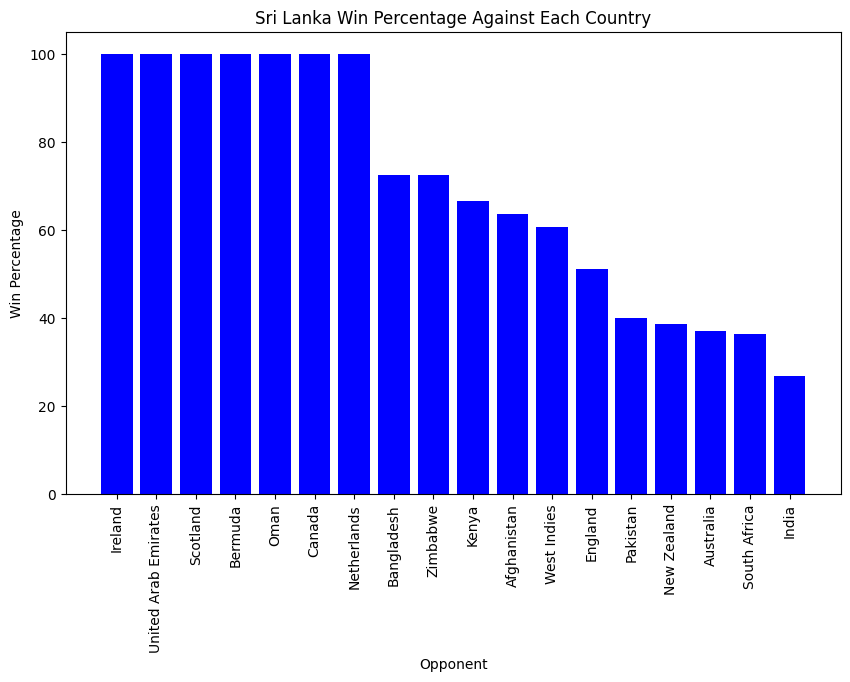

In [27]:
win_count_query = """
SELECT
    sri_lanka_matches.`Match ID`,
    CASE
        WHEN sri_lanka_matches.`Team 1` != 'Sri Lanka' THEN sri_lanka_matches.`Team 1`
        ELSE sri_lanka_matches.`Team 2`
    END AS Opponent,
    CASE WHEN sri_lanka_matches.Winner = 'Sri Lanka' THEN 1 ELSE 0 END AS Win
FROM sri_lanka_matches
INNER JOIN match_info ON sri_lanka_matches.`Match ID` = match_info.`Match ID`
"""
win_count_df = spark.sql(win_count_query).toPandas()
win_count_agg_df = win_count_df.groupby('Opponent').agg(
    Total_Matches=pd.NamedAgg(column='Match ID', aggfunc='count'),
    Wins=pd.NamedAgg(column='Win', aggfunc='sum')
).reset_index()
win_count_agg_df['Win_Percentage'] = (win_count_agg_df['Wins'] / win_count_agg_df['Total_Matches']) * 100
win_count_agg_df = win_count_agg_df.sort_values(by='Win_Percentage').reset_index(drop=True)

print(win_count_agg_df)

create_bar_plot(win_count_agg_df, 'Opponent', 'Win_Percentage', 'Sri Lanka Win Percentage Against Each Country', 'Opponent', 'Win Percentage')